Silhouette Score: 0.5620983751640836


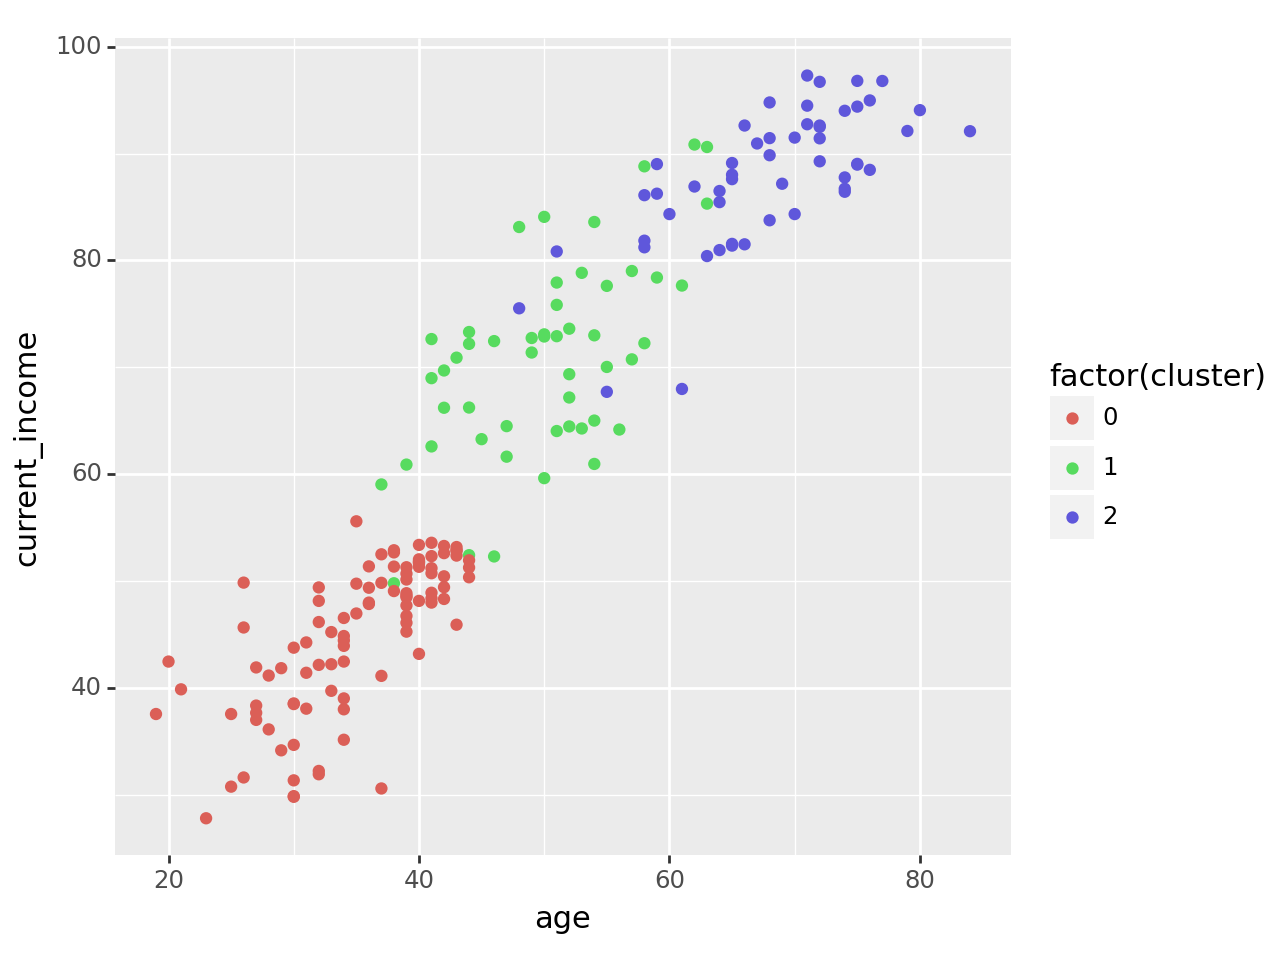

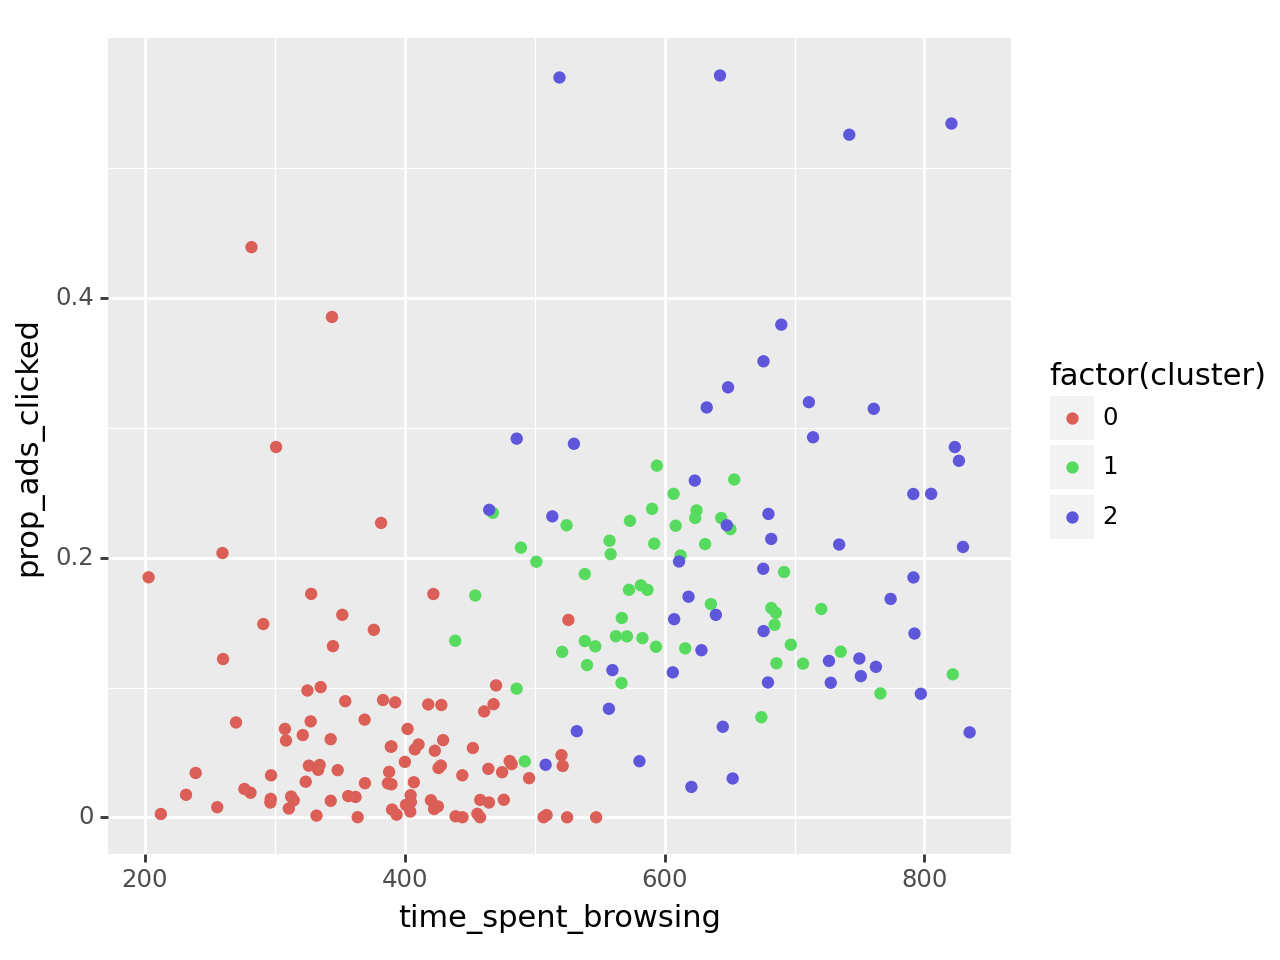

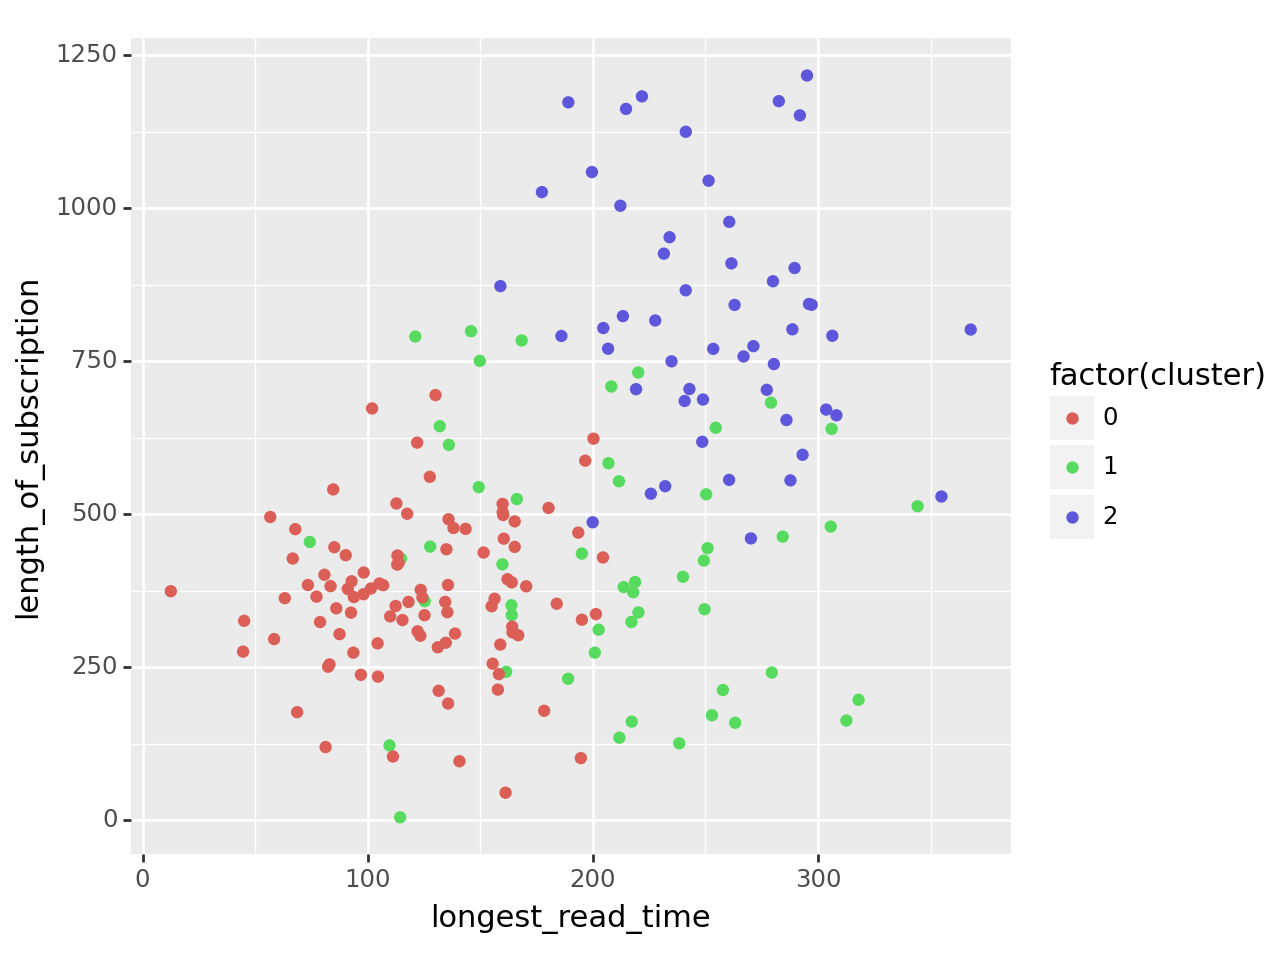

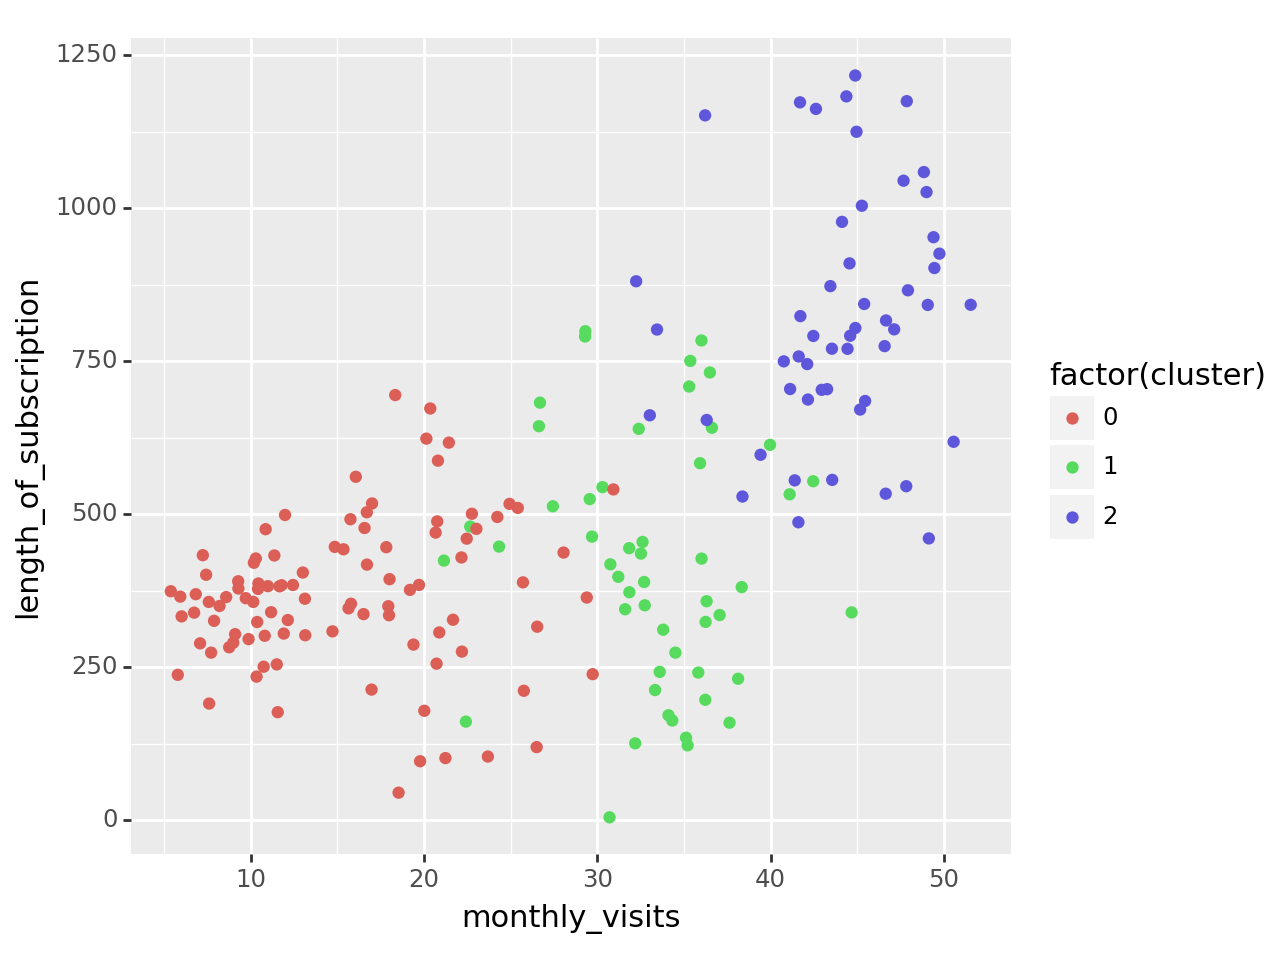

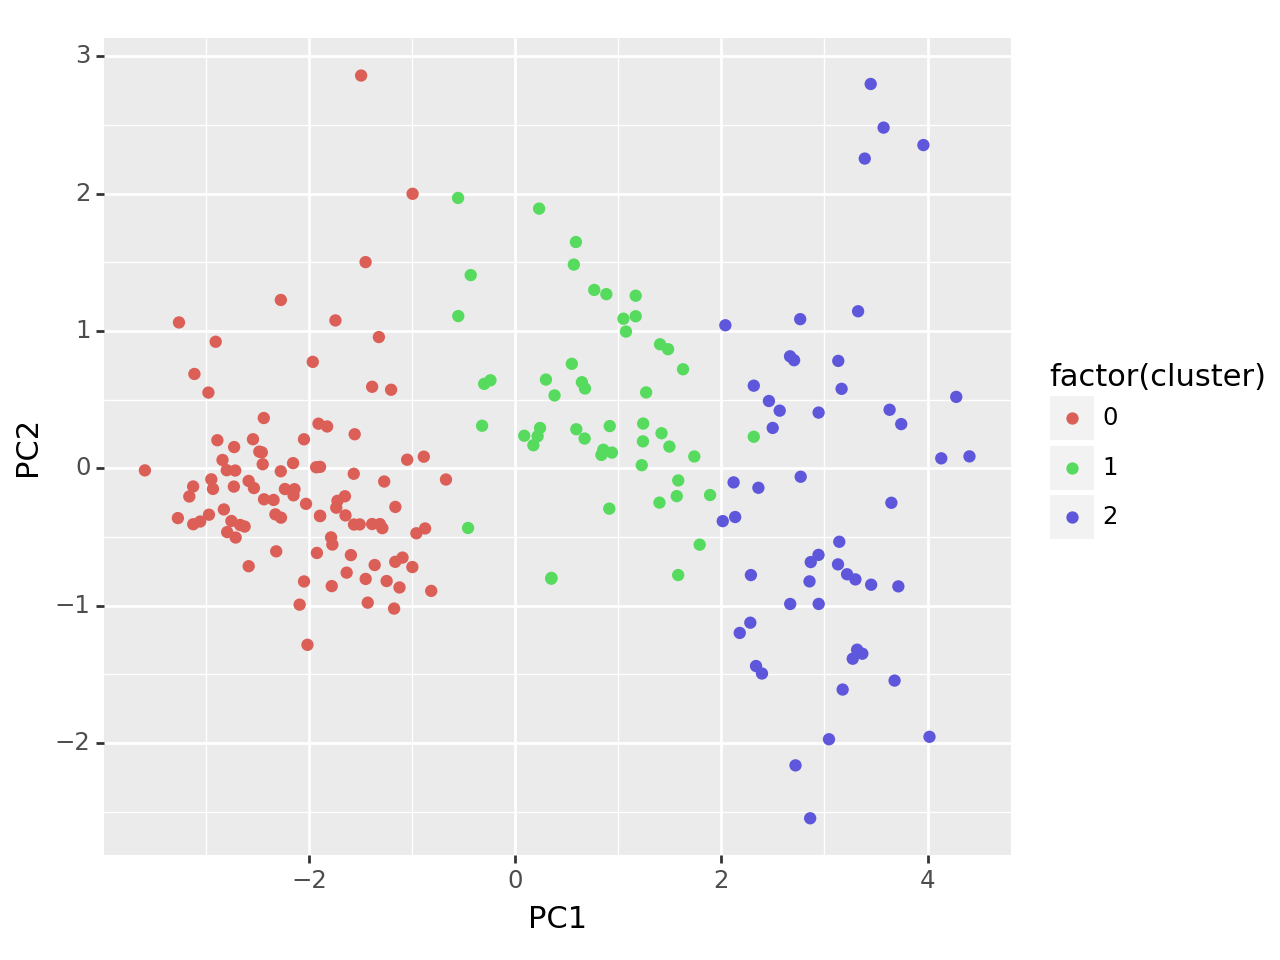



Results Section:
Silhouette Score: 0.5620983751640836


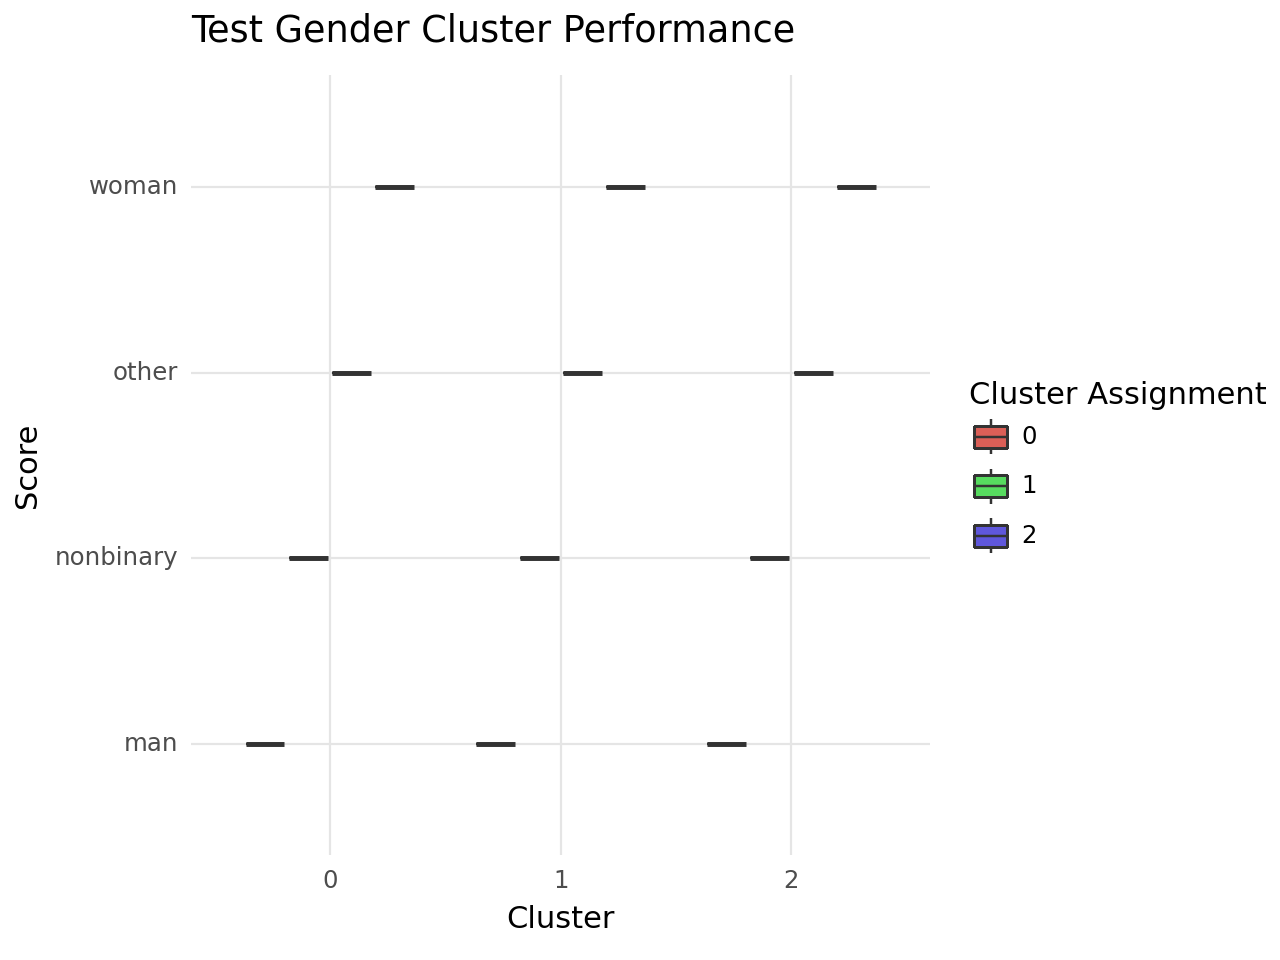

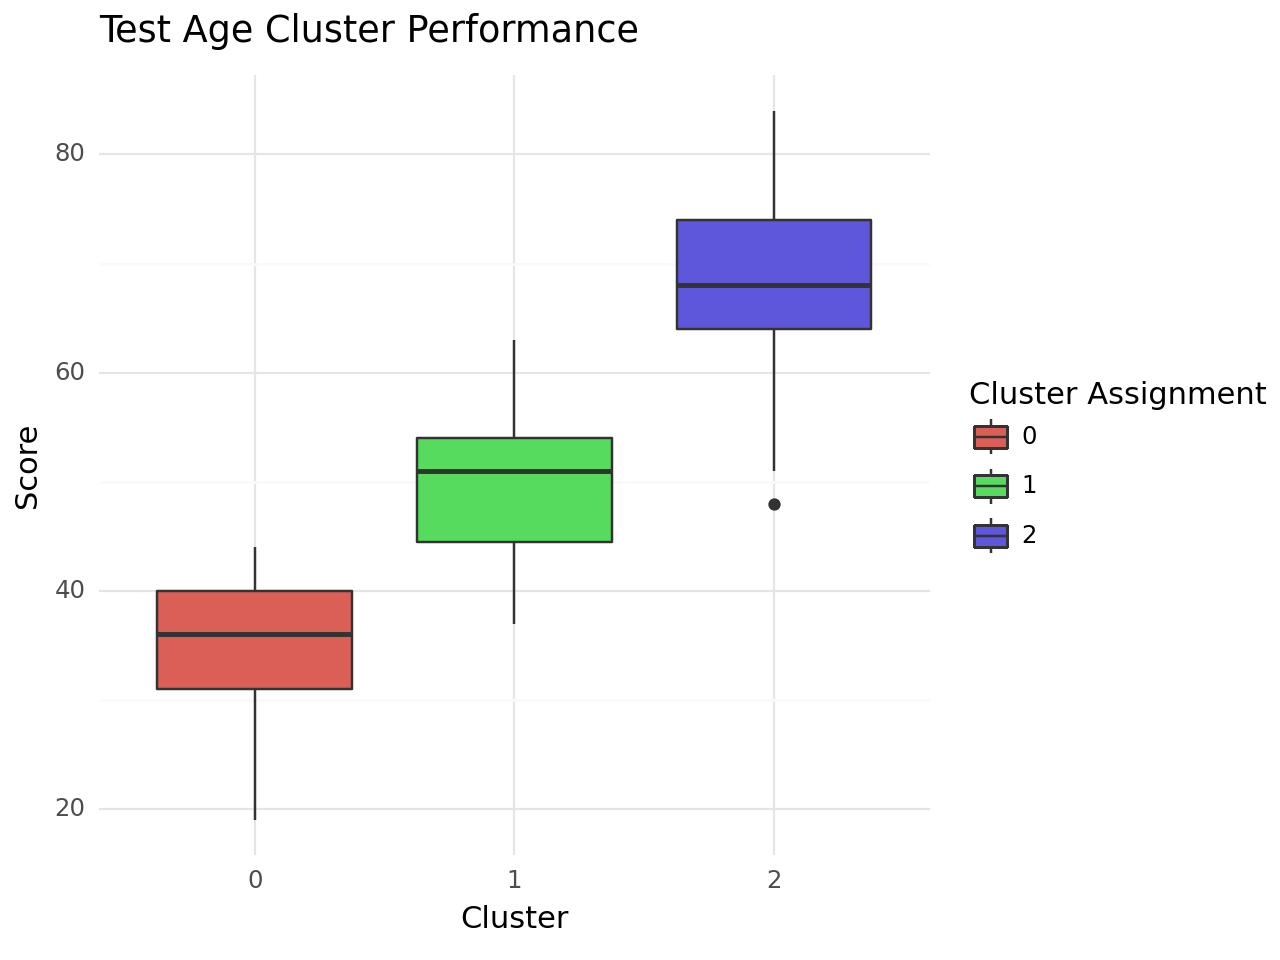

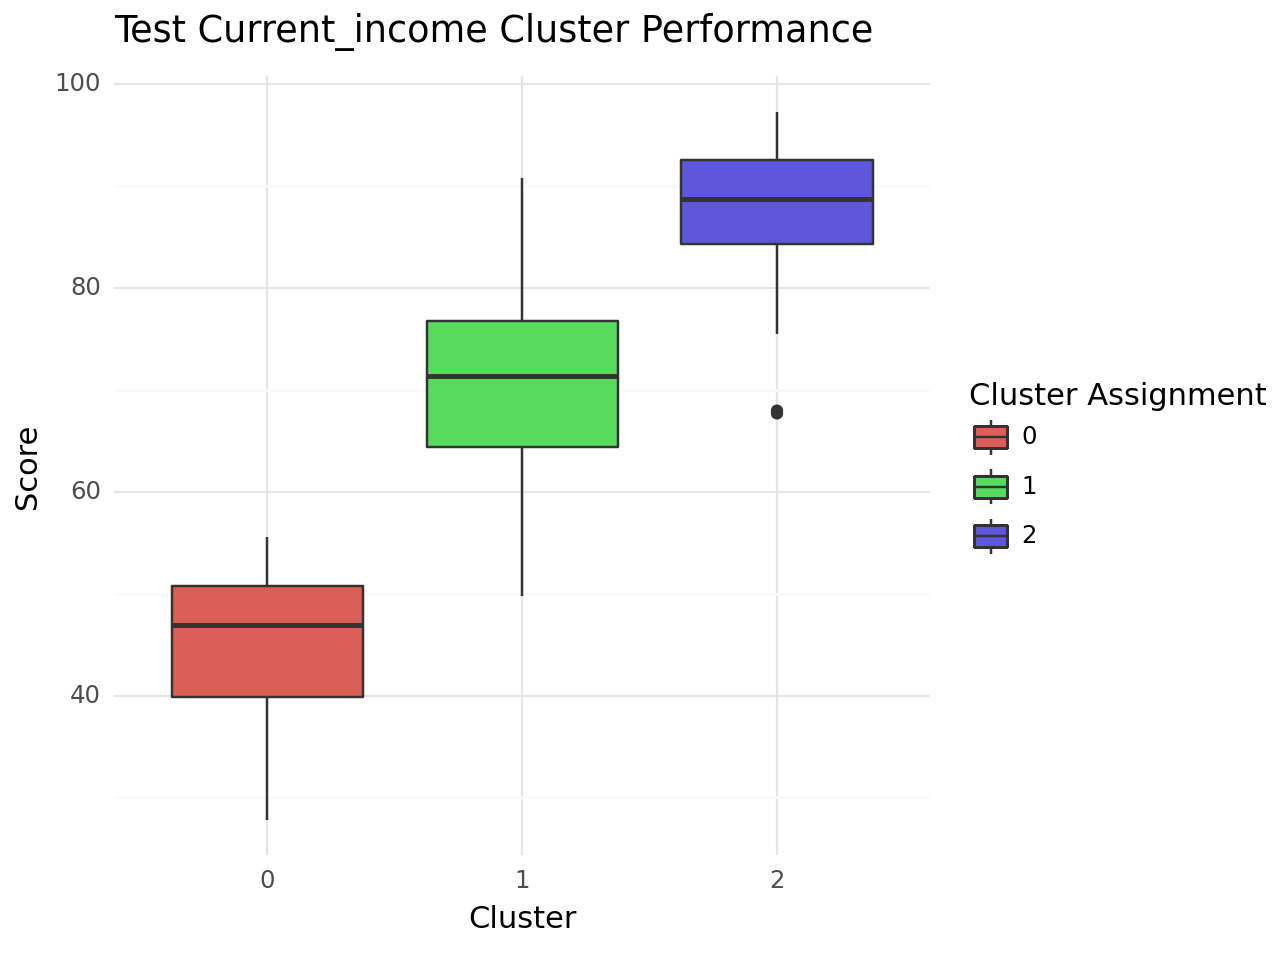

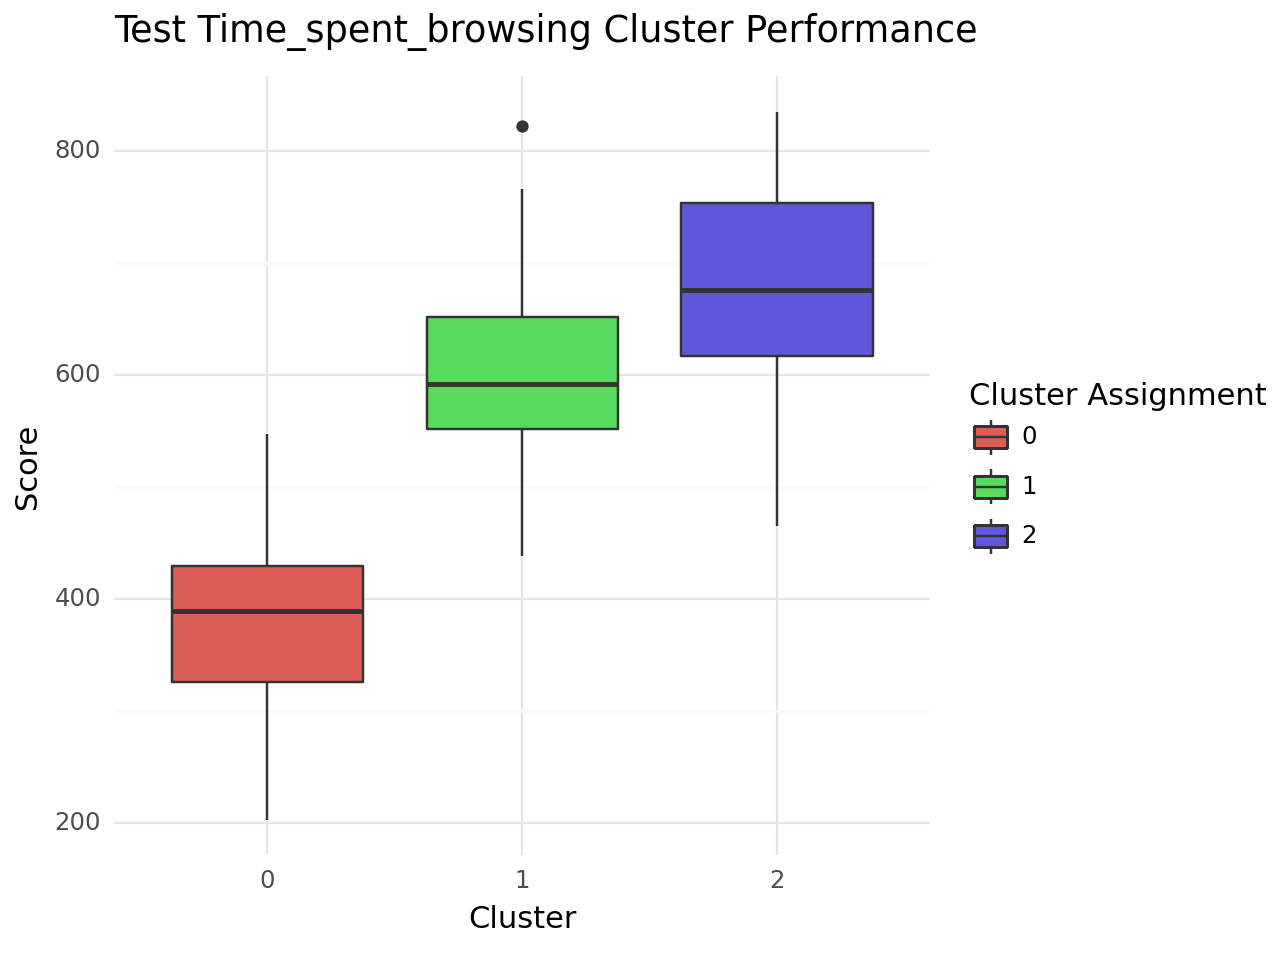

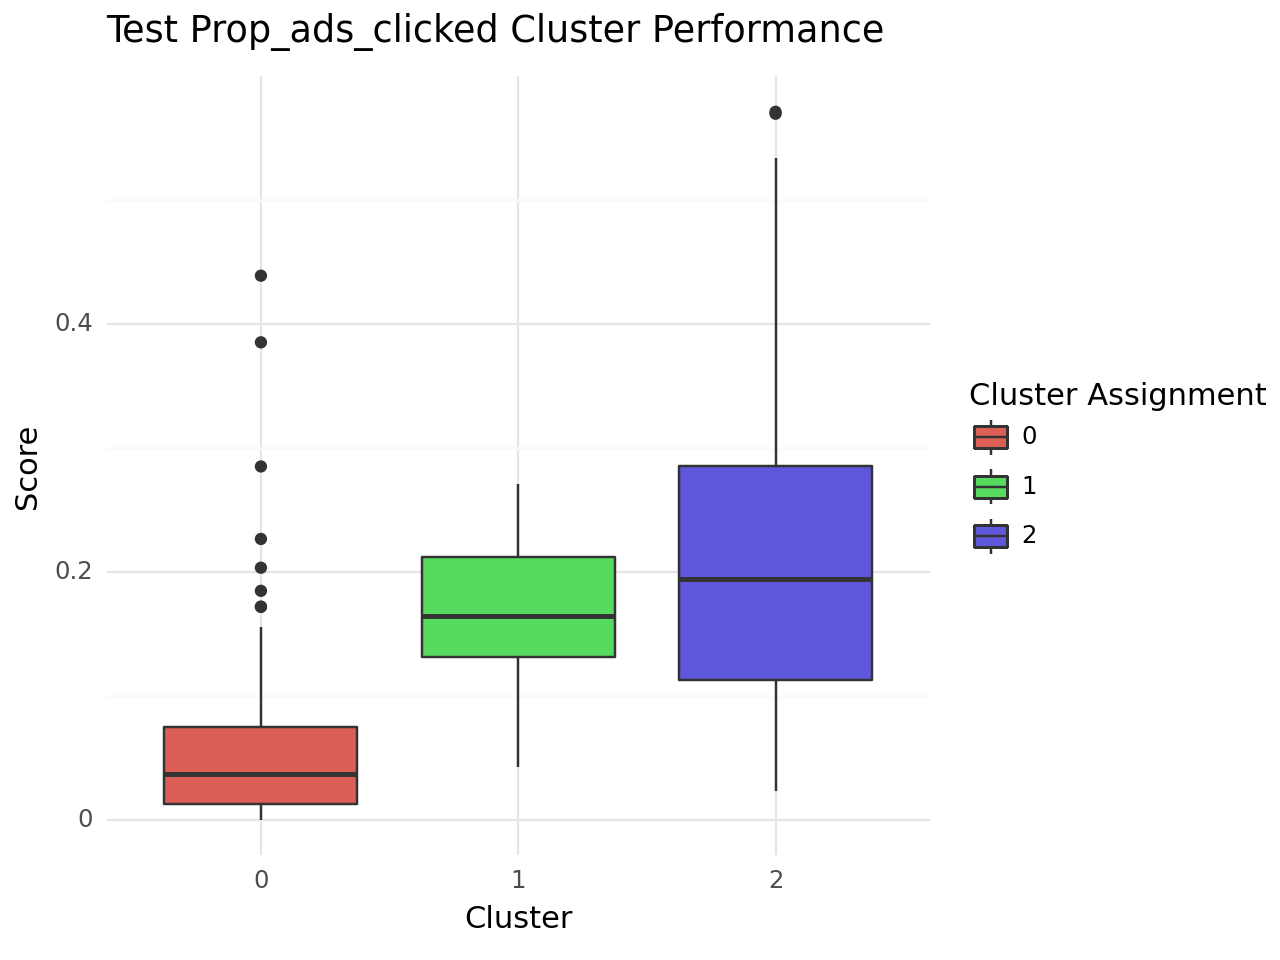

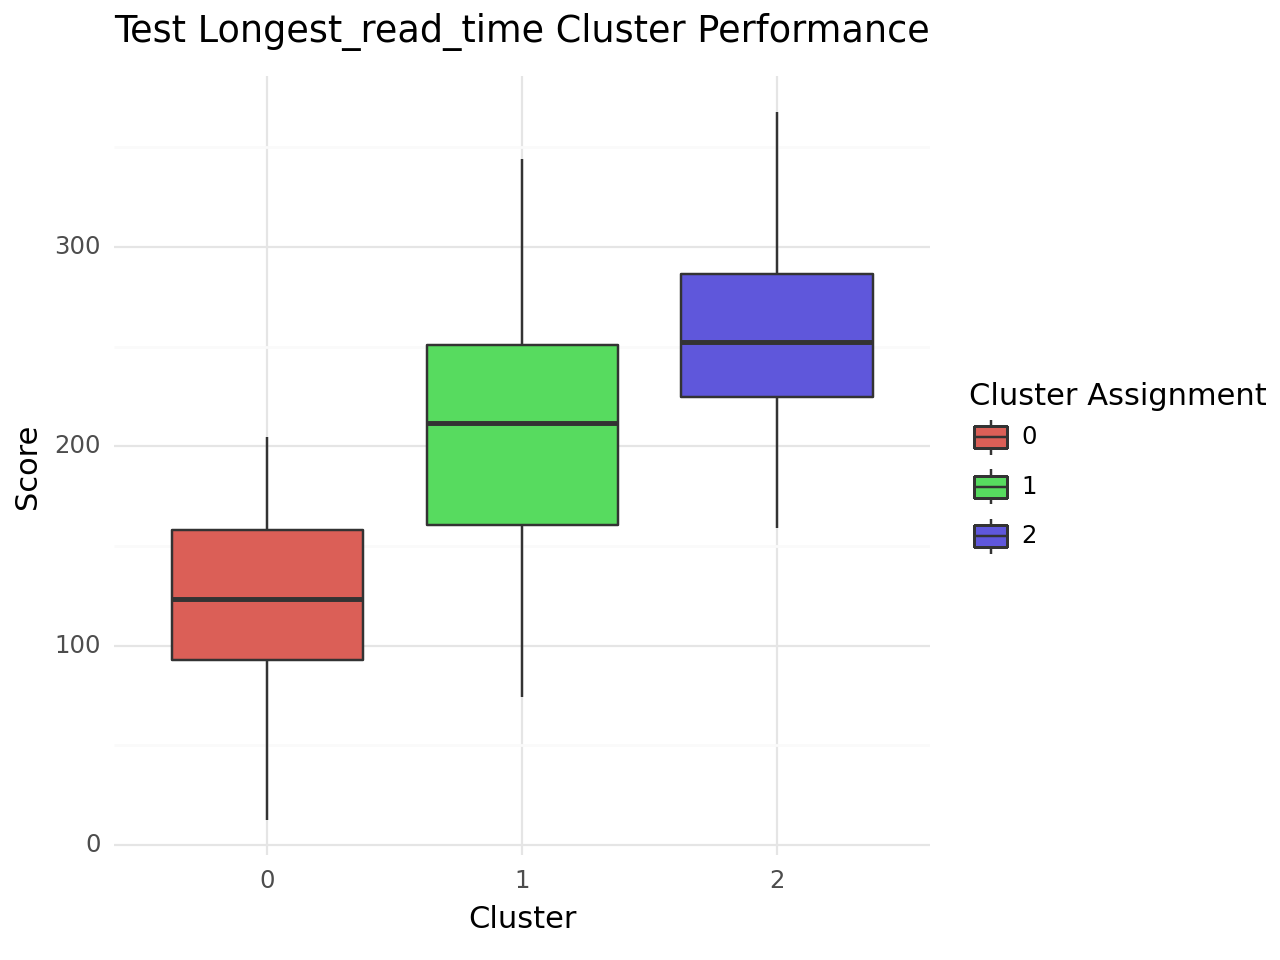

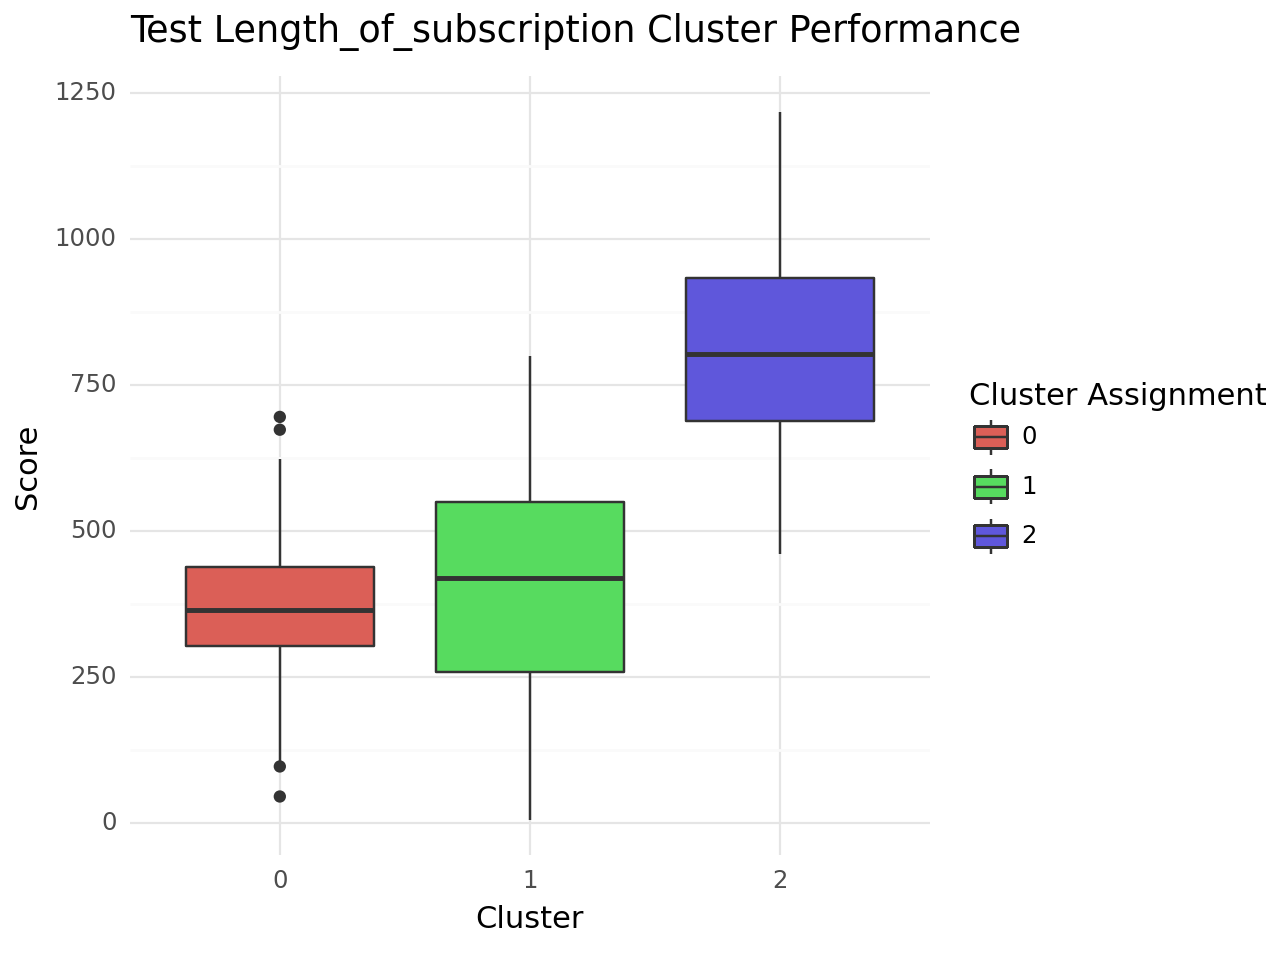

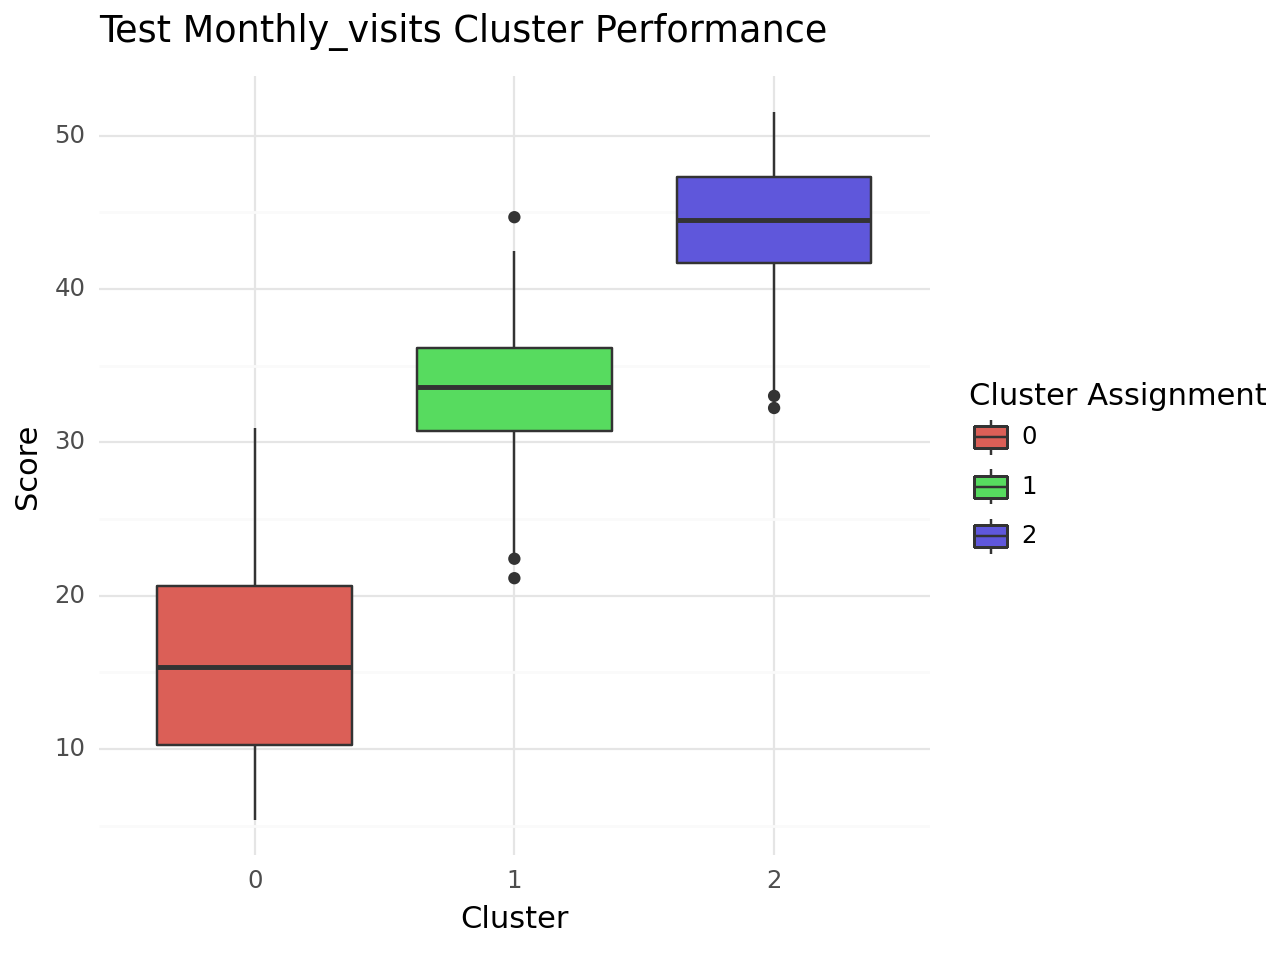

In [25]:

import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from plotnine import ggplot, aes, geom_point, labs, theme_minimal
from scipy.cluster.hierarchy import fcluster
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder #Z-score variables
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np
from plotnine import *
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer

# Subsetting the data for numerical features
url = "https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW3_behavioral.csv"
variables = ['gender','age', 'current_income', 'time_spent_browsing', 'prop_ads_clicked', 'longest_read_time', 'length_of_subscription', 'monthly_visits']
continuous_vars = ['age', 'current_income', 'time_spent_browsing', 'prop_ads_clicked', 'longest_read_time', 'length_of_subscription', 'monthly_visits']
data = pd.read_csv(url)
data.head()


# Displaying the scatterplots



X = data[variables]
X.dropna(inplace = True)
X.reset_index(inplace = True, drop = True)
# Z-score normalization
z = make_column_transformer((StandardScaler(), continuous_vars),(OneHotEncoder(),['gender']),
                            remainder = "passthrough")


# Choosing a clustering model


kmeans = KMeans(n_clusters=3,random_state = 42, init= 'k-means++')
pipe = Pipeline([("z",z),("clust",kmeans)])

labels = pipe.fit_predict(X)

sil_score = silhouette_score(pipe.transform(X), labels)
print("Silhouette Score:", sil_score)

data["cluster"] = labels


scatterplot_age_income = ggplot(data) + aes(x='age', y='current_income',color ='factor(cluster)') + geom_point()
scatterplot_browsing_adclicks = ggplot(data) + aes(x='time_spent_browsing', y='prop_ads_clicked',color ='factor(cluster)') + geom_point()
scatterplot_readtime_subscription = ggplot(data) + aes(x='longest_read_time', y='length_of_subscription', color ='factor(cluster)') + geom_point()
scatterplot_monthly_visits = ggplot(data) + aes(x='monthly_visits', y='length_of_subscription',color ='factor(cluster)') + geom_point()

print(scatterplot_age_income)
print(scatterplot_browsing_adclicks)
print(scatterplot_readtime_subscription)
print(scatterplot_monthly_visits)

pca = PCA(n_components=2)
pipe_pca = Pipeline([
    ("z", z),
    ("pca", pca)
])

pipe_pca.fit(X)

X_pca = pca.fit_transform(pipe.named_steps['z'].transform(data))

# Add principal components to the original dataframe
data['PC1'] = X_pca[:, 0]
data['PC2'] = X_pca[:, 1]

# Visualizing clusters using PC1 and PC2
g = ggplot(data) + aes(x='PC1', y='PC2', color='factor(cluster)') + geom_point()
print(g)  

scatter_plot = ggplot(data, aes(x='PC1', y='PC2', color='factor(cluster)')) + \
               geom_point() + \
               labs(title='Clusters using PCA', x='Principal Component 1', y='Principal Component 2') + \
               theme_minimal()



# Results 
print("\nResults Section:")
print("Silhouette Score:", sil_score)


# Display scatterplot
plt.show()

data["cluster_3"] = labels

for test in variables:
    title = "Test " + test.capitalize() + " Cluster Performance"
    print(ggplot(data, aes(x = "factor(cluster_3)", y = test)) 
          + geom_boxplot(aes(fill = "factor(cluster_3)")) + 
          theme_minimal() + 
          scale_fill_discrete(name = "Cluster Assignment") + 
          labs(x = "Cluster",
               y = "Score", 
               title = title))    




   Stocks  Productivity  Fashion  Celebrity  Cryptocurrency  Science  \
0       3            12        9          9               1        1   
1       1             0        1          1               0        8   
2       4             1       11          1               6       11   
3       2             6        8          1              15        1   
4       1             2        4          4               6        6   

   Technology  SelfHelp  Fitness  AI  
0           5         1        0   1  
1           4        10        4   0  
2           0         9        0   0  
3           1         9        8   0  
4           2         1        3   4  

Results Section:
Cluster Summary:
           Stocks  Productivity    Fashion  Celebrity  Cryptocurrency  \
cluster                                                                 
1        6.624113      7.312057   3.212766   2.035461        3.560284   
2        5.000000      5.000000   1.000000   5.333333       12.666667   
3     

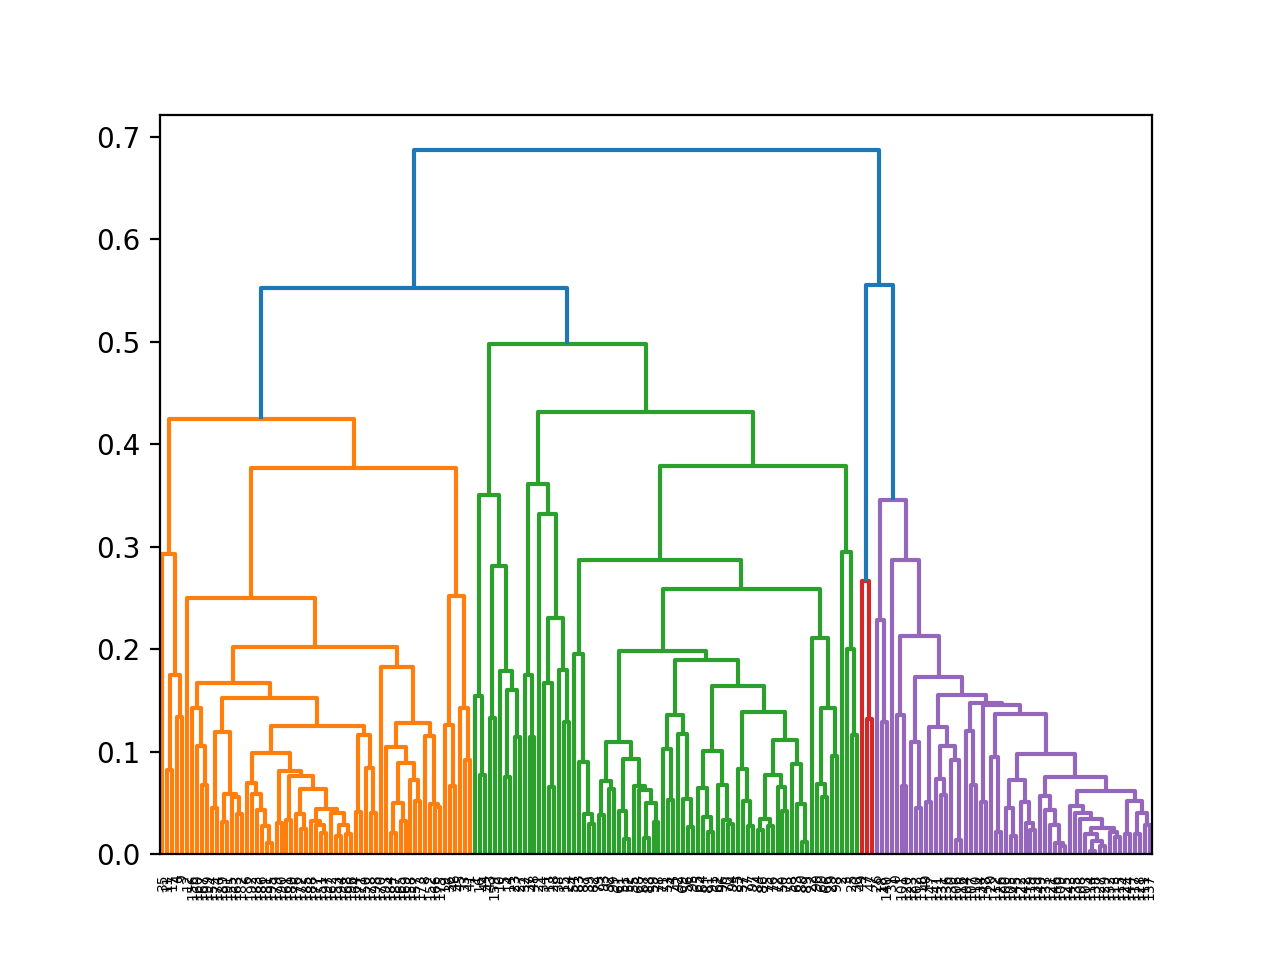

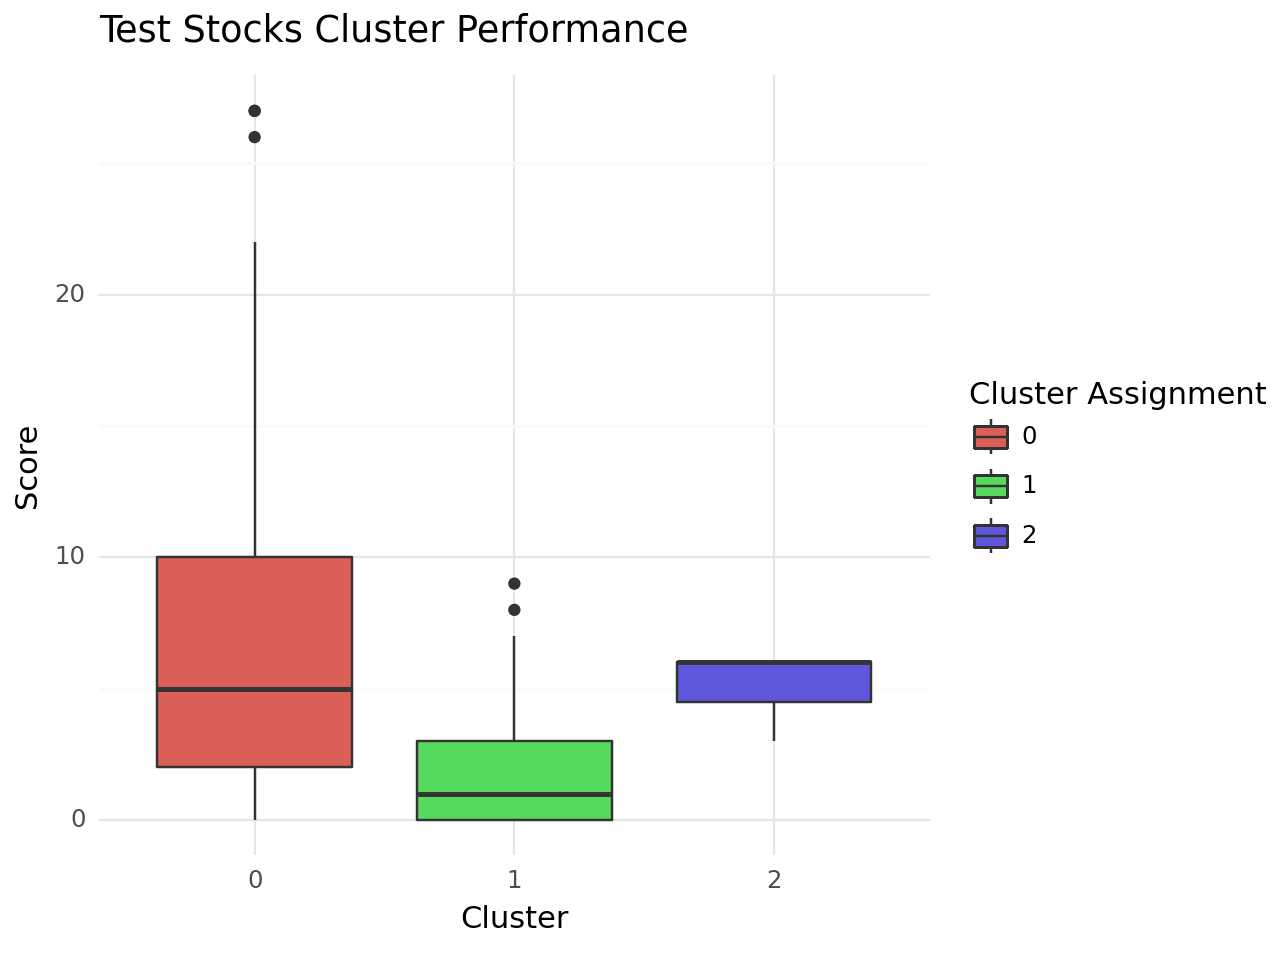

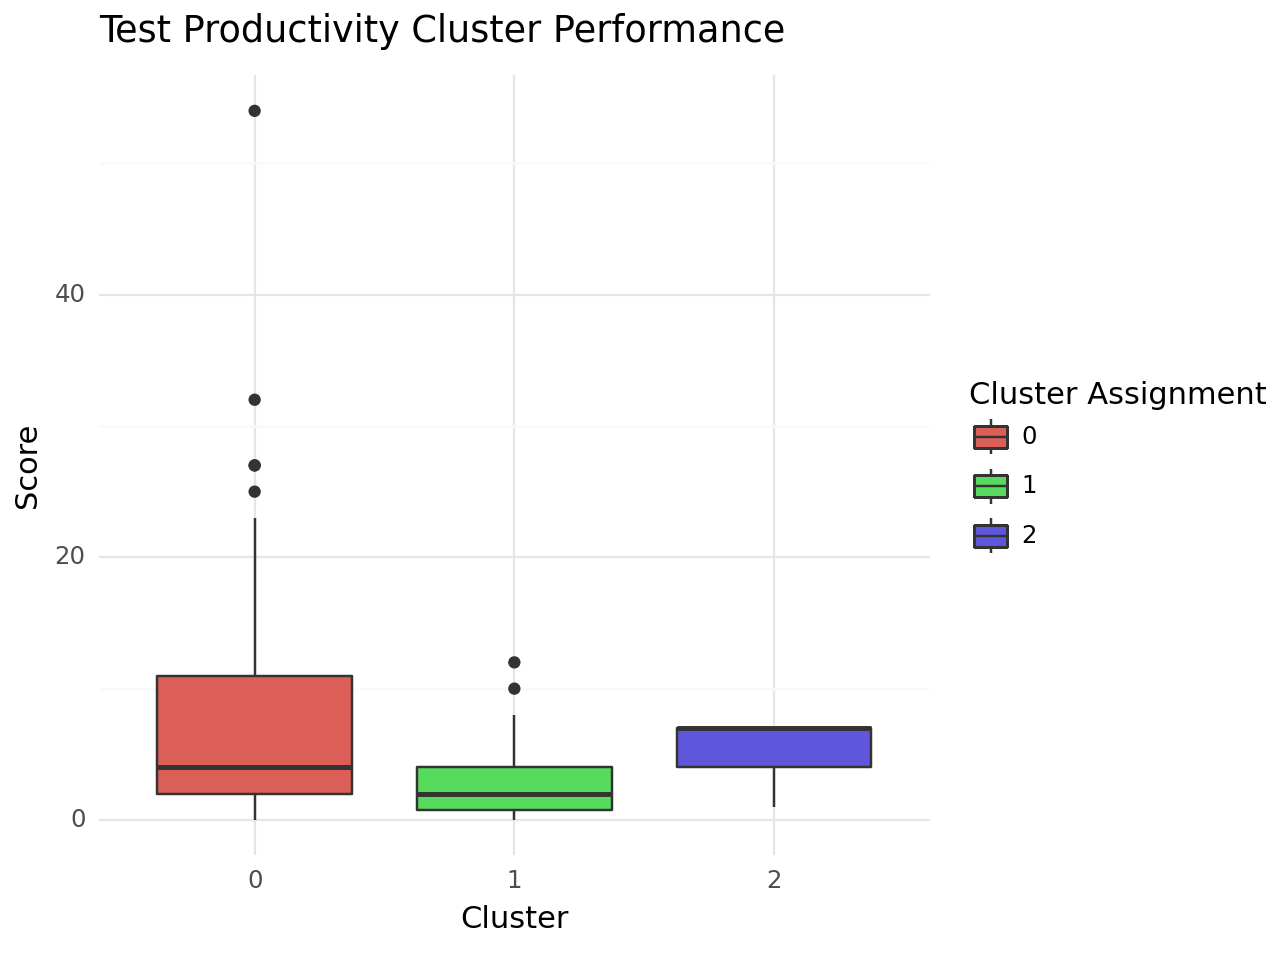

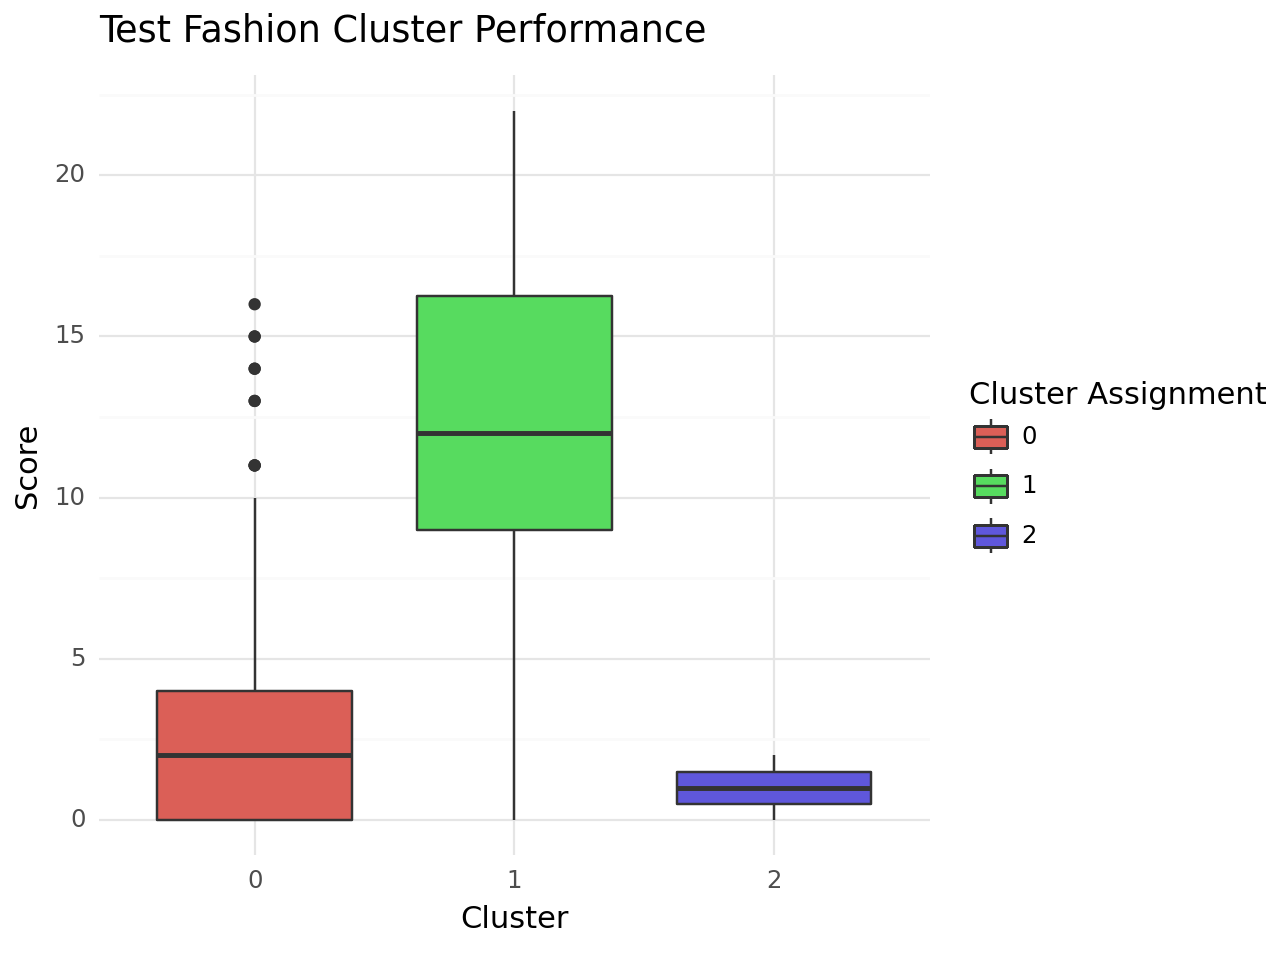

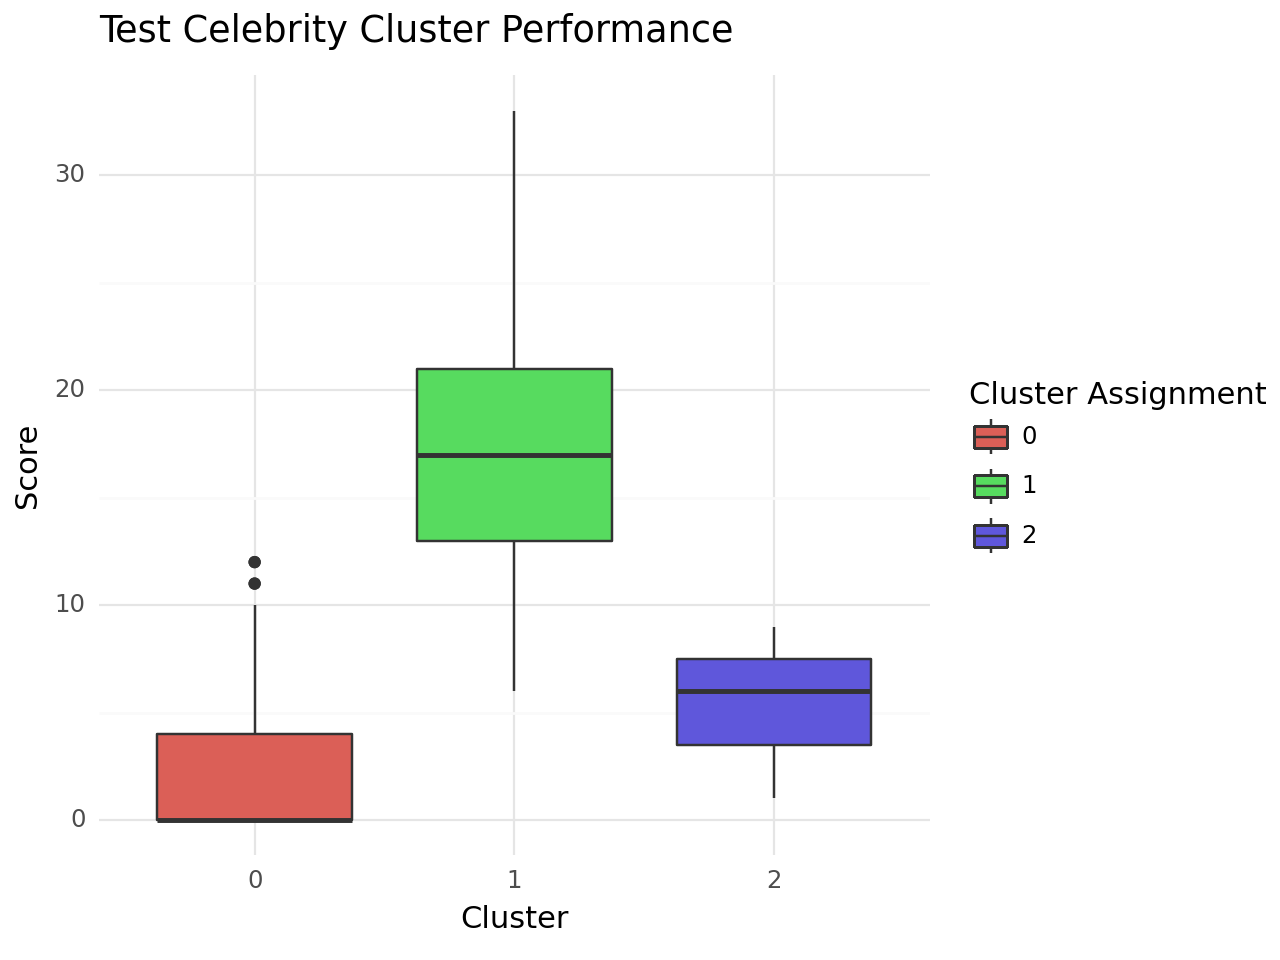

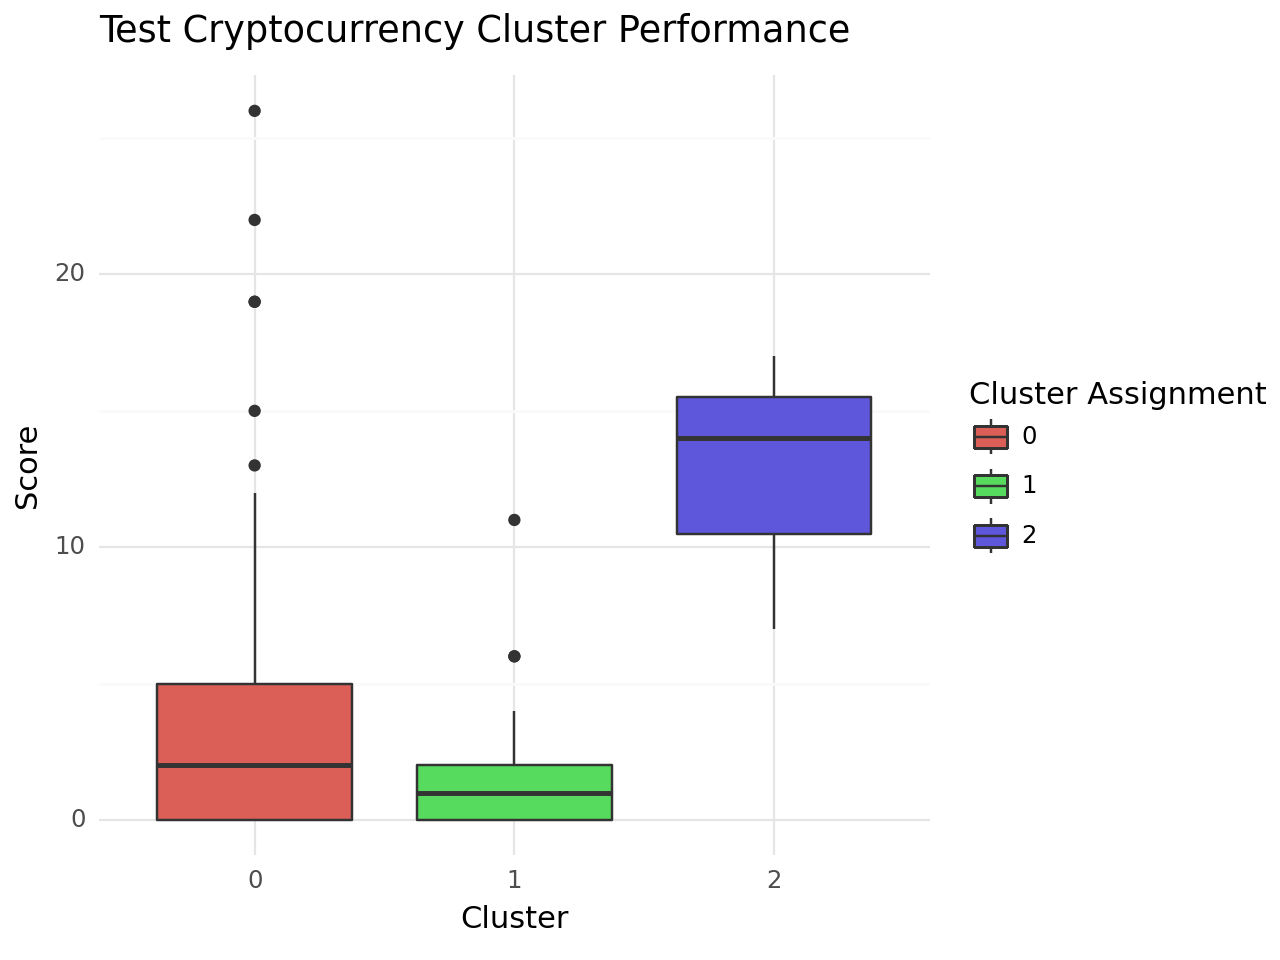

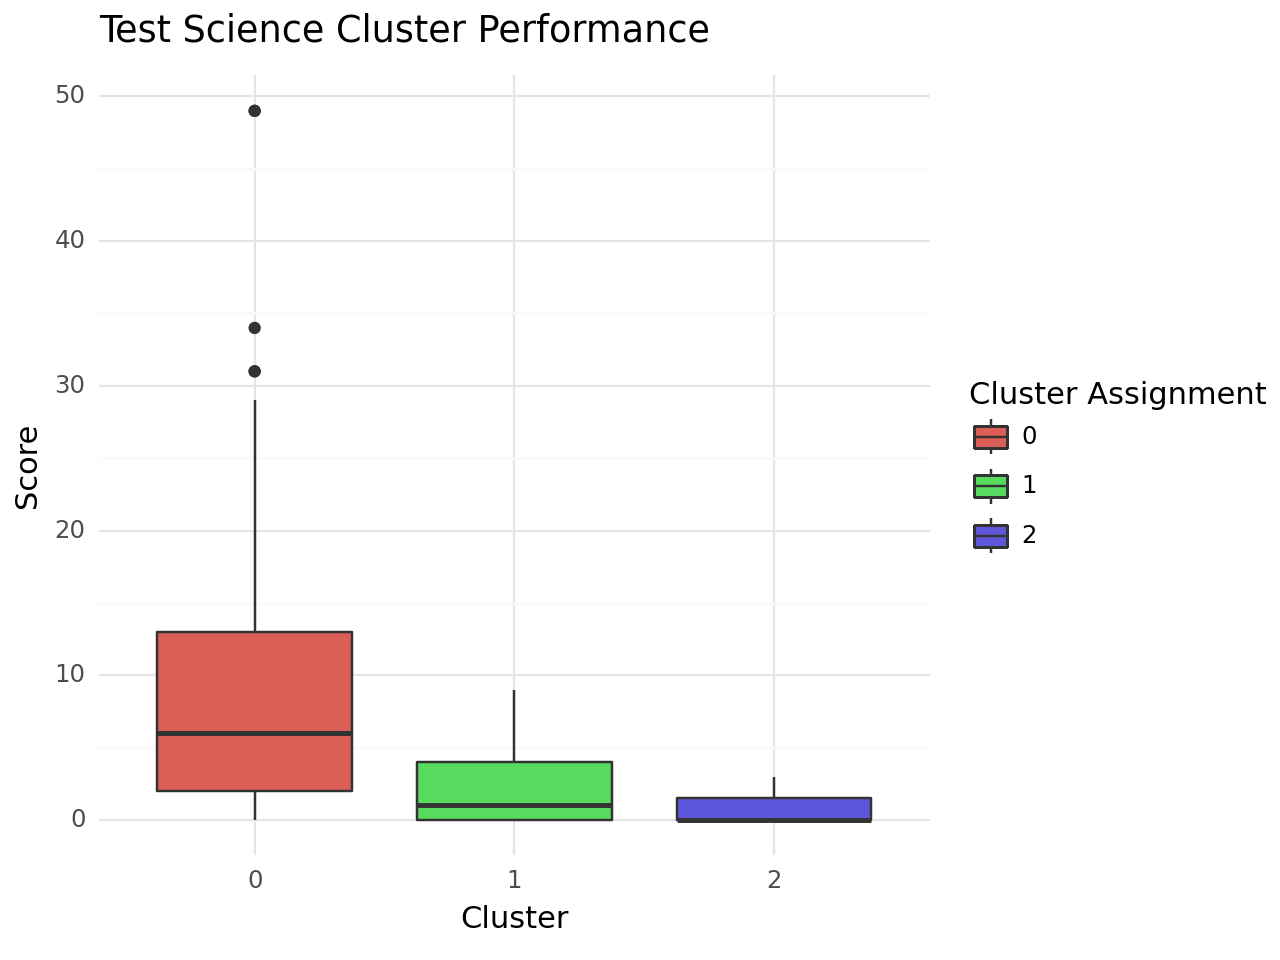

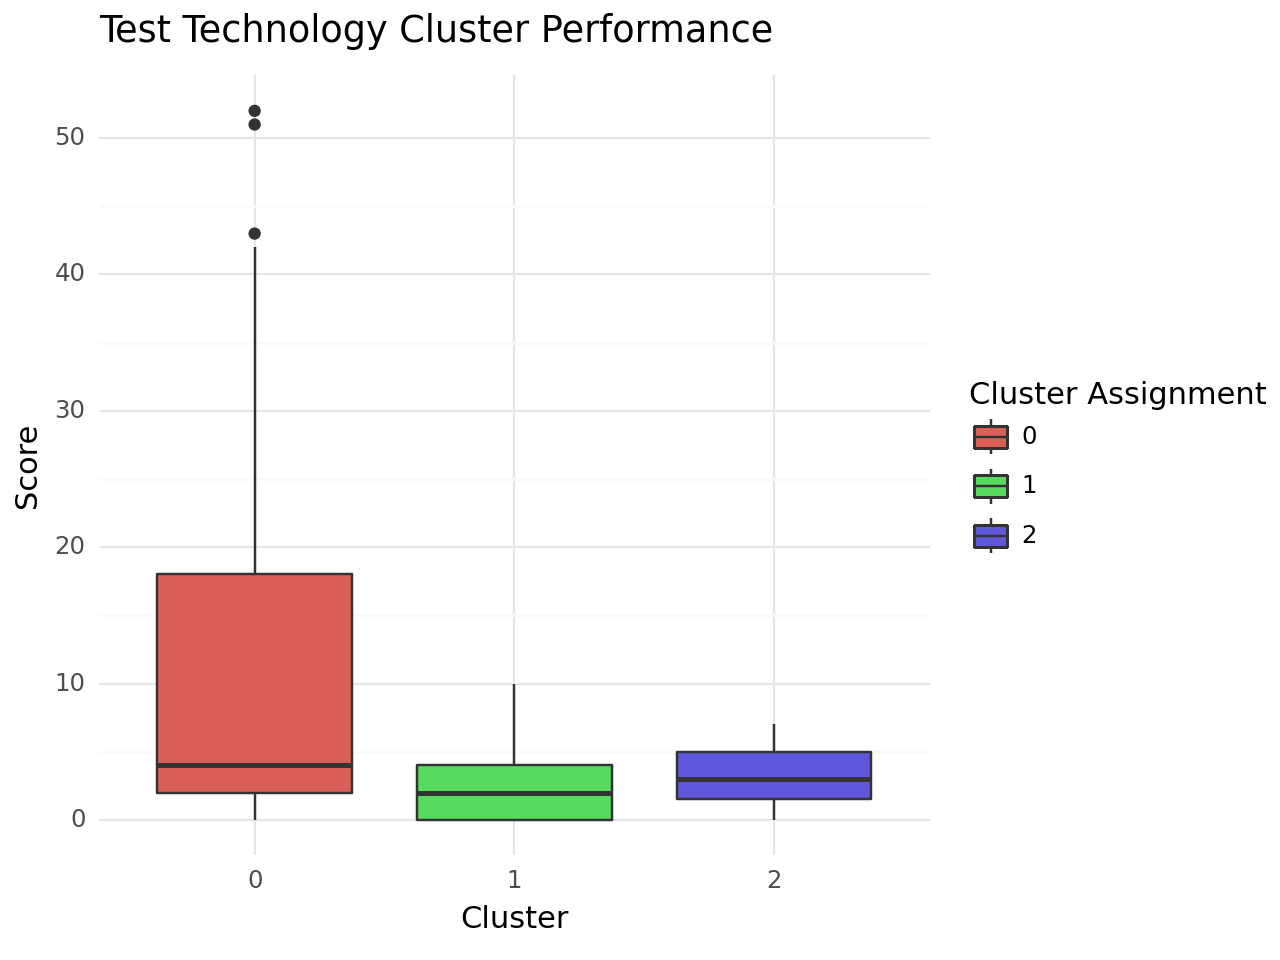

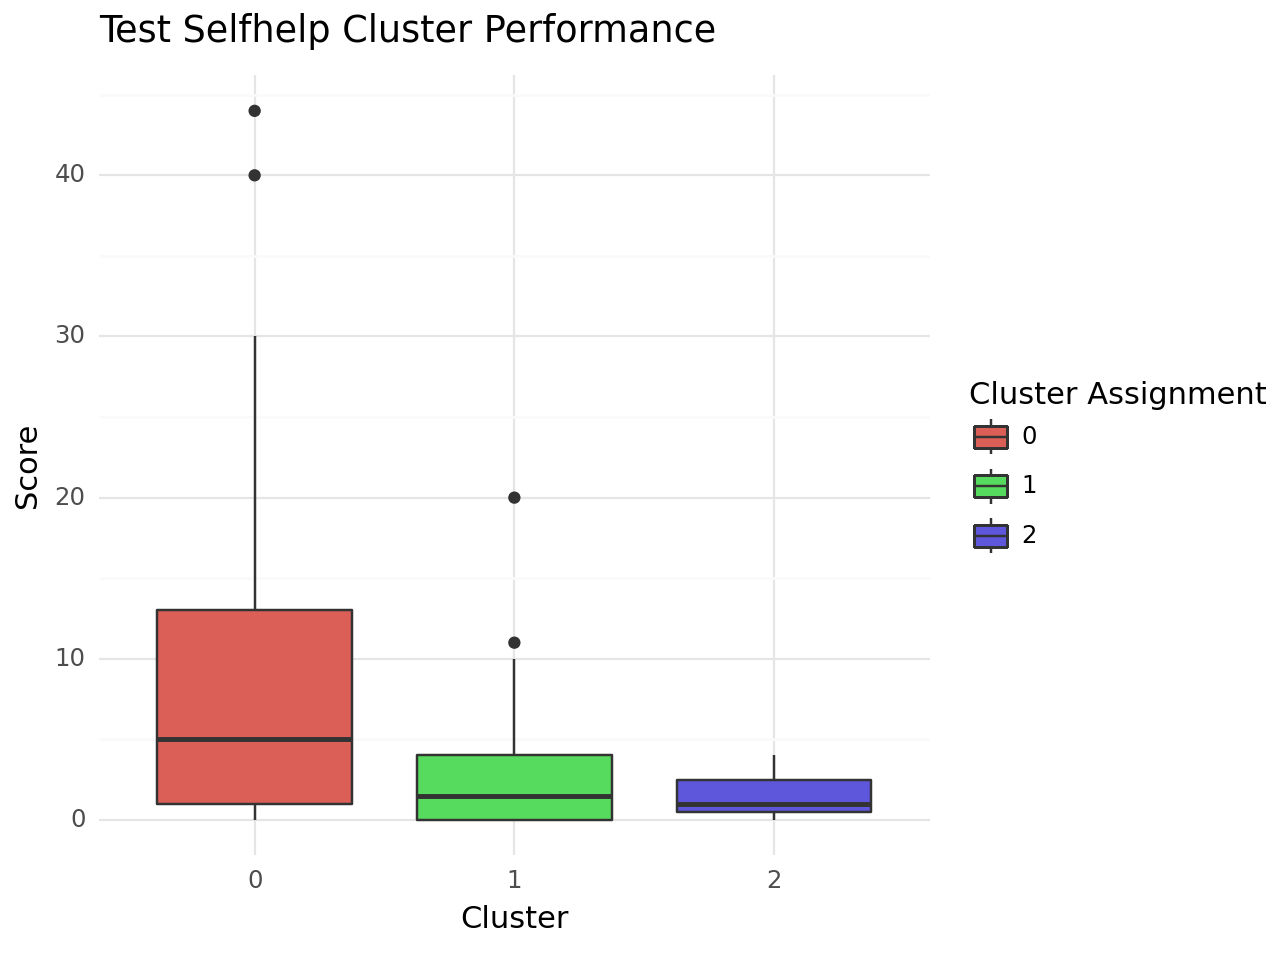

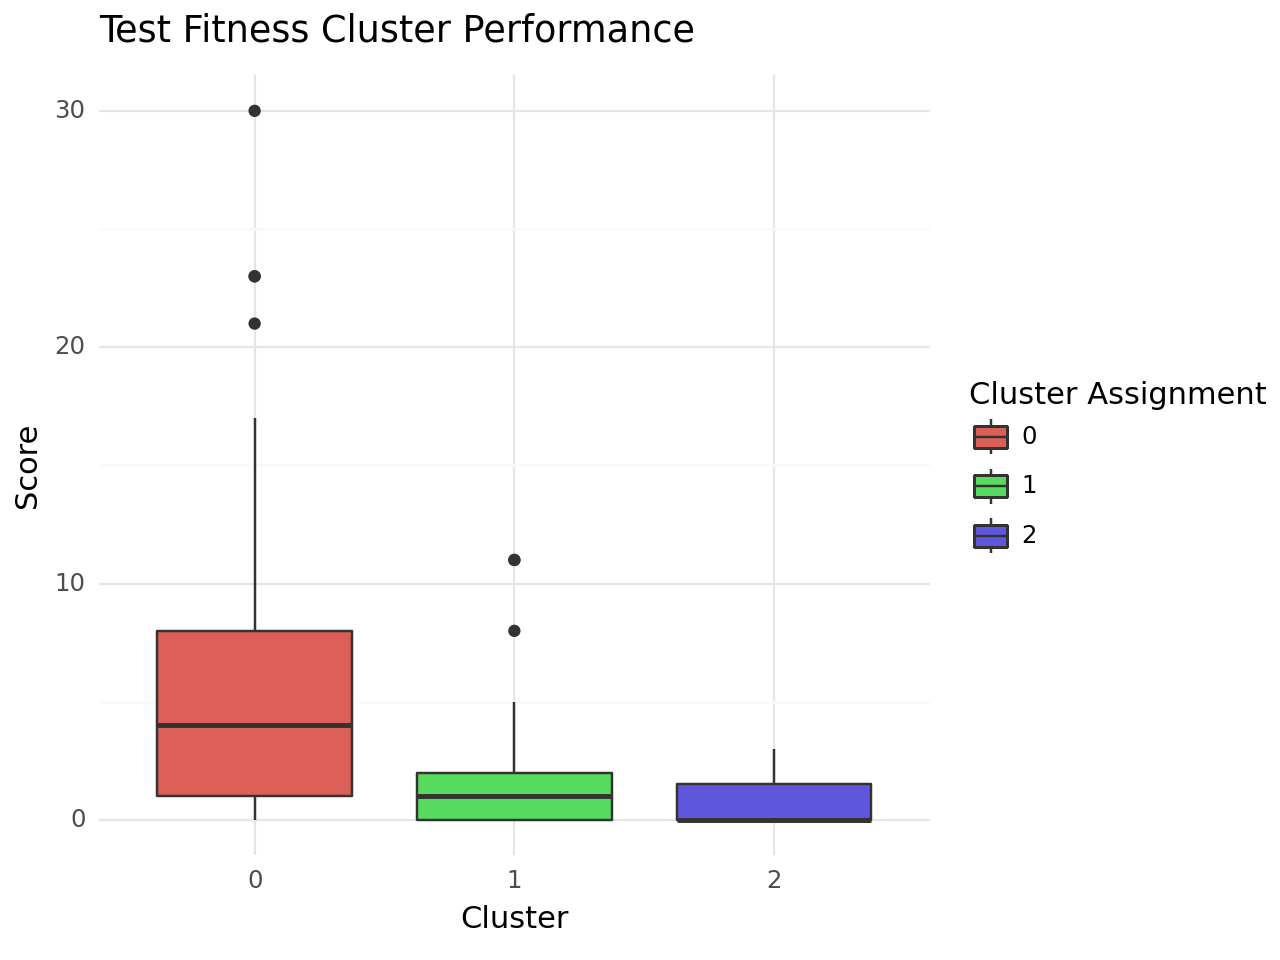

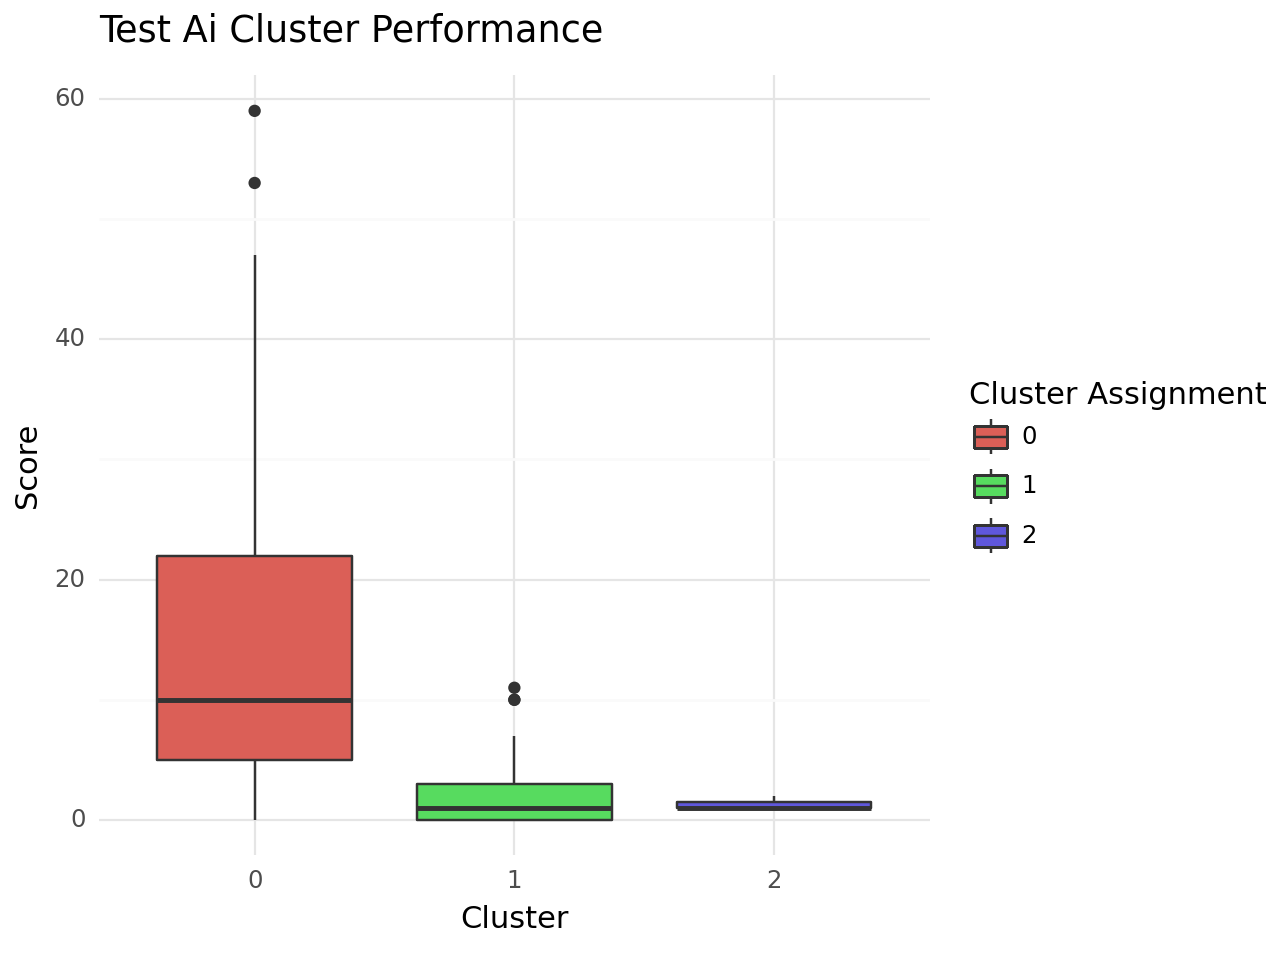

In [32]:
url2 = "https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW3_topics.csv"
data2 = pd.read_csv(url2)



clustering_data = data2.drop('id', axis=1)



# Generate linkage matrix
Z = linkage(clustering_data, method='average', metric='cosine')



# Add cluster labels to the original dataframe
data2['cluster'] = labels
compute_distances=True
hac = AgglomerativeClustering(n_clusters = None, affinity = "cosine", linkage = "average", distance_threshold = 1)  # come back and change the number of clusters

pipe = Pipeline([("model", hac)])


# fit model and get labels
print(clustering_data.head())
labels = pipe.fit_predict(clustering_data)

# assess
def plot_dendrogram(pipe, **kwargs):

    if "model" not in pipe.named_steps.keys():
        raise NameError("Your clustering pipeline step must be called 'model' for this function to work.")
    
    # create the counts of samples under each node
    counts = np.zeros(pipe.named_steps["model"].children_.shape[0])
    n_samples = len(pipe.named_steps["model"].labels_)
    for i, merge in enumerate(pipe.named_steps["model"].children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [pipe.named_steps["model"].children_, pipe.named_steps["model"].distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sch.dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(pipe, color_threshold = .5)

hac = AgglomerativeClustering(n_clusters = 3, affinity = "cosine", linkage = "average")  # come back and change the number of clusters

pipe = Pipeline([("model", hac)])
labels = pipe.fit_predict(clustering_data)




data2["cluster"] = fcluster(Z, t=3, criterion='maxclust')
cluster_summary = data2.groupby('cluster').mean()

print("\nResults Section:")
print("Cluster Summary:")
print(cluster_summary)

# Visualize 
ggplot(data2, aes(x='Stocks', y='Productivity', color='factor(cluster)')) + \
    geom_point() + \
    labs(title='Clusters using Cosine Hierarchical Clustering', x='Stocks', y='Productivity') + \
    theme_minimal()


data2["cluster_3"] = labels

for test in clustering_data:
    title = "Test " + test.capitalize() + " Cluster Performance"
    print(ggplot(data2, aes(x = "factor(cluster_3)", y = test)) 
          + geom_boxplot(aes(fill = "factor(cluster_3)")) + 
          theme_minimal() + 
          scale_fill_discrete(name = "Cluster Assignment") + 
          labs(x = "Cluster",
               y = "Score", 
               title = title))    